In [144]:
import os
import glob
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer
import spacy 
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import string
from flair.data import Sentence
from flair.models import SequenceTagger
from nltk.util import ngrams
from nltk.corpus import stopwords
twtkz = TweetTokenizer()

In [39]:
nlp = spacy.load('en_core_web_lg')
nlp.max_length = nlp.max_length *1.5
f_t = SequenceTagger.load('ner')

def fx(s):
    return s[4:-4]

2022-08-04 16:07:18,073 loading file C:\Users\William\.flair\models\ner-english\4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-08-04 16:07:20,677 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [40]:
books = glob.glob('**/*.txt')
print(books)

['books\\01 - The Fellowship Of The Ring.txt', 'books\\02 - The Two Towers.txt', 'books\\03 - The Return Of The King.txt']


In [41]:
shelf = [{},{},{}]
for i,b in enumerate(books):
    with open(b) as f:
        t =  f.read()
        shelf[i] = {'title':fx(b), 'text': t, 'norm_text':t.lower(),'n_words':len(t), 'n_sents': len(sent_tokenize(t))}
    print(fx(b), "\t--\t", shelf[i]['n_words'], shelf[i]['n_sents'])

s\01 - The Fellowship Of The Ring 	--	 1021113 13407
s\02 - The Two Towers 	--	 834790 12513
s\03 - The Return Of The King 	--	 724043 9139


In [42]:
for i,b in enumerate(shelf):
    t = b['text']
    ss = [Sentence(s, use_tokenizer=True) for s in sent_tokenize(t)]
    x = nlp(b['text'])
    f_t.predict(ss)
    b['entities'] = x.ents
    b['f_ents'] = [e for f in ss for e in f.get_spans('ner')]

In [155]:
distractions = ['orcs','orc','elf','elves','hobbit','hobbits','ring','river','dwarf','dwarves',
                'bree','hill','rose','tree','moon','sun','wild', 'north','south',
                'him','one','old','black','white','grey','west','battle','wind','lady',
                'dark','hand','master','king','lord','will','dead','hope', 'three','green',
                'evil','enemy','eye','took','helm','farewell','shadow','gate','her','ents',
                'snow','need','folk','wonder','stone','she','man','men', 'sword']
for b in shelf:
    b['characters'] = [e.text.lower() for e in b['entities'] if e.label_ == "PERSON" and e.text.lower() not in distractions]
    b['fchars'] = [e.text.lower() for e in b['f_ents'] if e.tag == "PER" and e.text.lower() not in distractions]
    print(len(b['characters']), len(b['entities']), "|||", len(b['fchars']))

4194 8000 ||| 4891
3584 6234 ||| 4143
3299 6274 ||| 3843


In [156]:
def most_common(adict, n):
    return [(k, adict[k]) for k in sorted(adict, key=adict.get, reverse=True)][:n]

In [158]:
def extract_ngrams(data, st,ed):
    a = [w for w in twtkz.tokenize(data) if w not in string.punctuation and w not in stopwords.words('english')] #word_tokenize normally
    r = []
    for i in range(st,ed+1):
        b = [' '.join(grams) for grams in ngrams(a, i)]
        r = r+ b
    return r

In [159]:
def bar3(X, y1,y2,y3,title,ylab,xlab,yn, w=1.5, scale=5):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    xa = np.arange(len(X)) *scale
    b1b = ax.bar(xa - w,    y1, color = 'brown', width = w, label=yn[0])#'Fellowship')
    b2b = ax.bar(xa + 0.0,  y2, color = 'orange', width = w, label=yn[1])#'Towers')
    b3b = ax.bar(xa + w,    y3, color = 'red', width = w, label =yn[2])#'Return')
    ax.set_ylabel(ylab)#'Mentions')
    ax.set_xlabel(xlab)#"Characters")
    ax.set_title(title)#'Mentions of most common book1 characters in each book')
    ax.set_xticks(xa, X)
    ax.legend()

    ax.bar_label(b1b, padding=3)
    ax.bar_label(b2b, padding=3)
    ax.bar_label(b3b, padding=3)

    fig.set_size_inches(20, 9, forward=True)
    nb = []
    for j,i in enumerate(xa):
        tmp = [y1[j], y2[j],y3[j]]
        nb.append(sum(tmp)/len(tmp))
        plt.plot([i-w,i, i+w], tmp, '-',c='royalblue', linewidth=3)
    plt.plot(xa, np.array(nb) +250, '-', c='seagreen', linewidth=2)

    plt.show()

In [160]:
for b in shelf:
    #tmp = {ch:b['text'].lower().count(ch.lower()) for ch in b['characters']}
    #tmp2 = {ch:b['text'].lower().count(ch.lower()) for ch in b['fchars']}
    tn = extract_ngrams(b['norm_text'], 1, 2)
    tmp  = Counter([wd for wd in tn if wd in b['characters']]) 
    tmp2 = Counter([wd for wd in tn if wd in b['fchars']]) 
    b['mcc'] = tmp
    b['fcc'] = tmp2


In [161]:
for b in shelf:
    print(*[c[0][:7] for c in most_common(b['mcc'],20)],sep='\t')
    print(*[c[1] for c in most_common(b['mcc'],20)],sep='\t')
    print()

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	gollum	baggins	sauron	saruman	butterb	lórien	mr frod
1035	446	396	269	219	208	201	198	148	124	117	116	94	64	61	55	52	50	44	42

frodo	sam	gandalf	gollum	aragorn	gimli	legolas	pippin	saruman	sméagol	merry	treebea	faramir	éomer	boromir	rohan	gondor	fangorn	uglúk	orthanc
456	393	334	288	287	185	178	177	173	141	135	128	126	114	89	81	75	49	49	47

sam	frodo	gandalf	pippin	merry	aragorn	faramir	denetho	éomer	rohan	éowyn	gimli	beregon	legolas	minas t	sauron	nay	saruman	cotton	imrahil
440	368	298	273	221	219	155	118	104	98	96	77	71	67	49	40	38	37	35	33



In [162]:
b = most_common(shelf[0]['mcc'],20)#.most_common(20)
b2 = shelf[1]['mcc']
b3 = shelf[2]['mcc']
X = [c[0] for c in b]
y1 = [c[1] for c in b]
y2 = [b2.get(c[0]) if b2.get(c[0]) else 0 for c in b]
y3 = [b3.get(c[0]) if b3.get(c[0]) else 0 for c in b]
print(*X,sep='\t')
print(*y1,sep='\t')
print(*y2,sep='\t')
print(*y3,sep='\t')

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	gollum	baggins	sauron	saruman	butterbur	lórien	mr frodo
1035	446	396	269	219	208	201	198	148	124	117	116	94	64	61	55	52	50	44	42
456	334	393	6	135	177	287	0	89	13	2	185	178	288	6	33	173	0	21	0
368	298	440	28	221	273	219	0	27	31	6	77	67	19	9	40	37	18	9	0


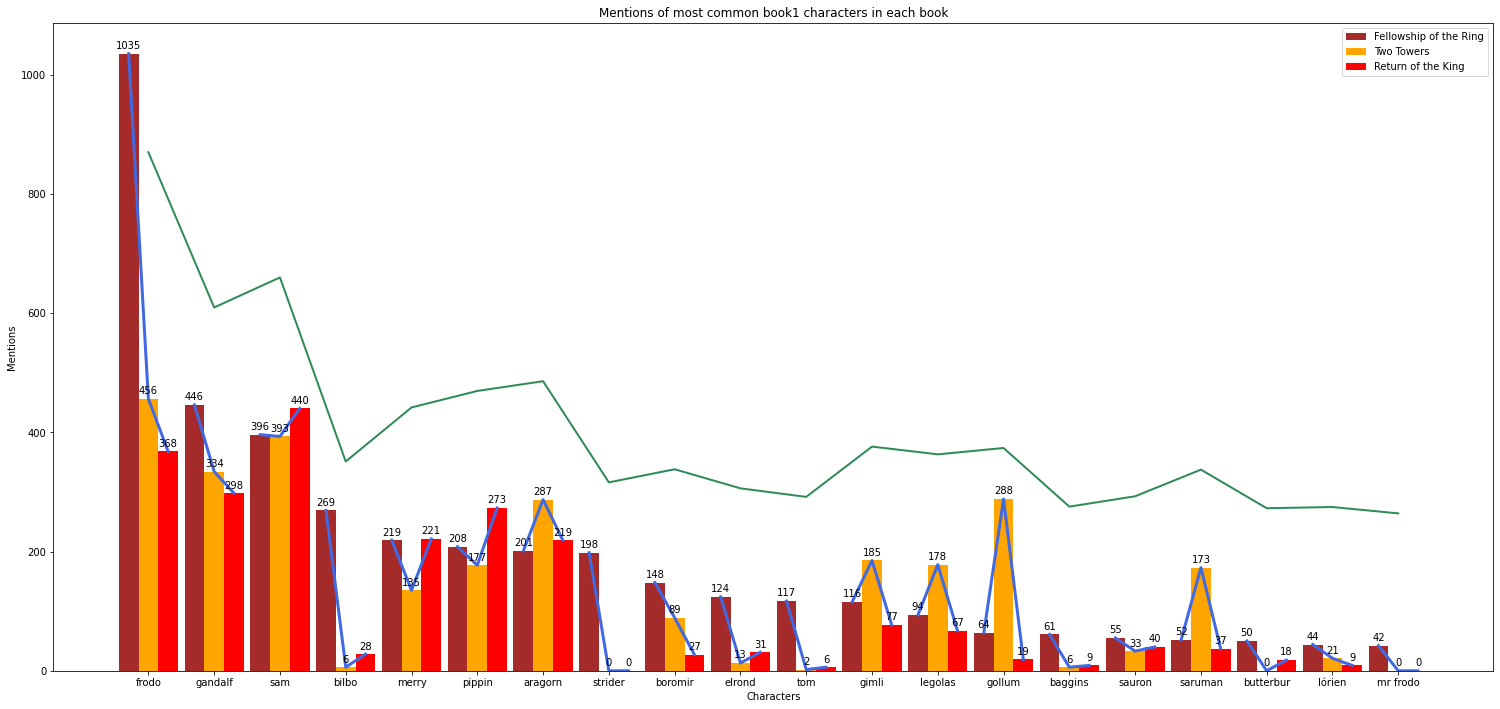

In [163]:
bar3(X, y1,y2,y3,
        'Mentions of most common book1 characters in each book',
        "Mentions","Characters", ["Fellowship of the Ring","Two Towers","Return of the King"], 
        w=1.5, scale=5)

In [164]:
for b in shelf:
    print(*[c[0][:7] for c in most_common(b['fcc'],20)],sep='\t')
    print(*[c[1] for c in most_common(b['fcc'],20)],sep='\t')
    print()

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	rivende	moria	mordor	gollum	baggins	sauron	saruman
1035	446	396	269	219	208	201	198	148	124	117	116	94	87	75	66	64	61	55	52

frodo	sam	gandalf	gollum	aragorn	gimli	legolas	pippin	saruman	sméagol	merry	treebea	faramir	théoden	isengar	éomer	preciou	boromir	rohan	gondor
456	393	334	288	287	185	178	177	173	141	135	128	126	120	114	114	98	89	81	75

sam	frodo	gandalf	pippin	merry	aragorn	faramir	gondor	denetho	éomer	rohan	éowyn	théoden	mordor	gimli	beregon	legolas	tall	minas t	forth
440	368	298	273	221	219	155	151	118	104	98	96	93	89	77	71	67	62	49	48



In [165]:
b = most_common(shelf[0]['fcc'],20)#.most_common(20)
b2 = shelf[1]['fcc']
b3 = shelf[2]['fcc']
X = [c[0] for c in b]
y1 = [c[1] for c in b]
y2 = [b2.get(c[0]) if b2.get(c[0]) else 0 for c in b]
y3 = [b3.get(c[0]) if b3.get(c[0]) else 0 for c in b]
print(*X,sep='\t')
print(*y1,sep='\t')
print(*y2,sep='\t')
print(*y3,sep='\t')

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	rivendell	moria	mordor	gollum	baggins	sauron	saruman
1035	446	396	269	219	208	201	198	148	124	117	116	94	87	75	66	64	61	55	52
456	334	393	6	135	177	287	14	89	13	2	185	178	16	14	69	288	6	33	173
368	298	440	28	221	273	219	13	27	31	6	77	67	16	0	89	19	9	40	37


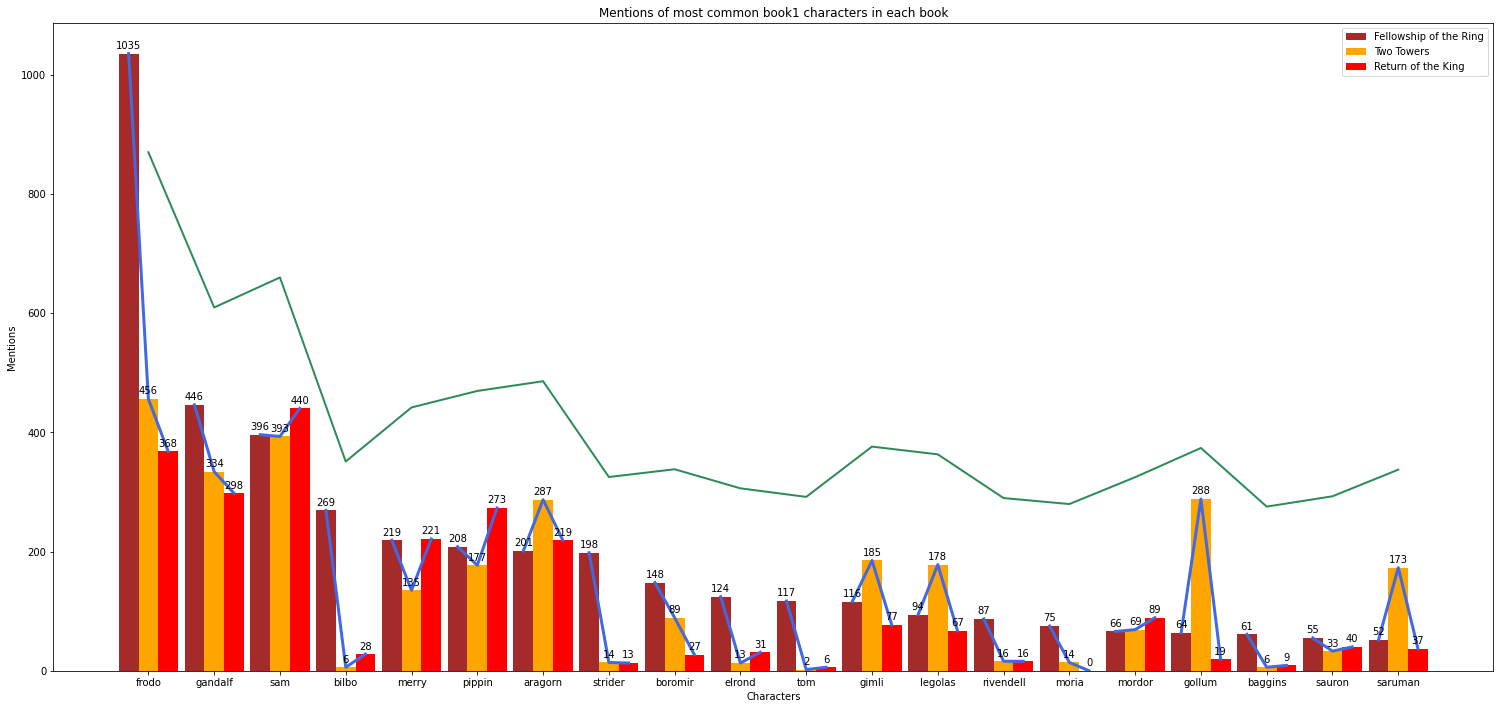

In [166]:
bar3(X, y1,y2,y3,
        'Mentions of most common book1 characters in each book',
        "Mentions","Characters", ["Fellowship of the Ring","Two Towers","Return of the King"], 
        w=1.5, scale=5)

In [167]:
for b in shelf:
    wt = extract_ngrams(b['norm_text'],2, 3)
    cd = Counter(wt)
    b['three_count'] = cd

('said frodo', 220) ('said gandalf', 135) ('could see', 67) ('said aragorn', 65) ('said sam', 62) ('said merry', 59) ('long ago', 55) ('bag end', 55) ('said pippin', 55) ('let us', 51)
('said frodo', 136) ('said aragorn', 127) ('said gandalf', 120) ('said gimli', 91) ('said sam', 86) ('said legolas', 79) ('said faramir', 72) ('far away', 65) ('let us', 64) ('could see', 60)
('said gandalf', 94) ('mr frodo', 77) ('said frodo', 77) ('said sam', 75) ('said pippin', 70) ('said aragorn', 55) ('said merry', 54) ('minas tirith', 49) ('far away', 42) ('frodo said', 40)


In [173]:
b = most_common(shelf[0]['three_count'],15)
b2 = shelf[1]['three_count']
b3 = shelf[2]['three_count']
X = [c[0] for c in b]
y1 = [c[1] for c in b]
y2 = [b2.get(c[0]) if b2.get(c[0]) else 0 for c in b]
y3 = [b3.get(c[0]) if b3.get(c[0]) else 0 for c in b]

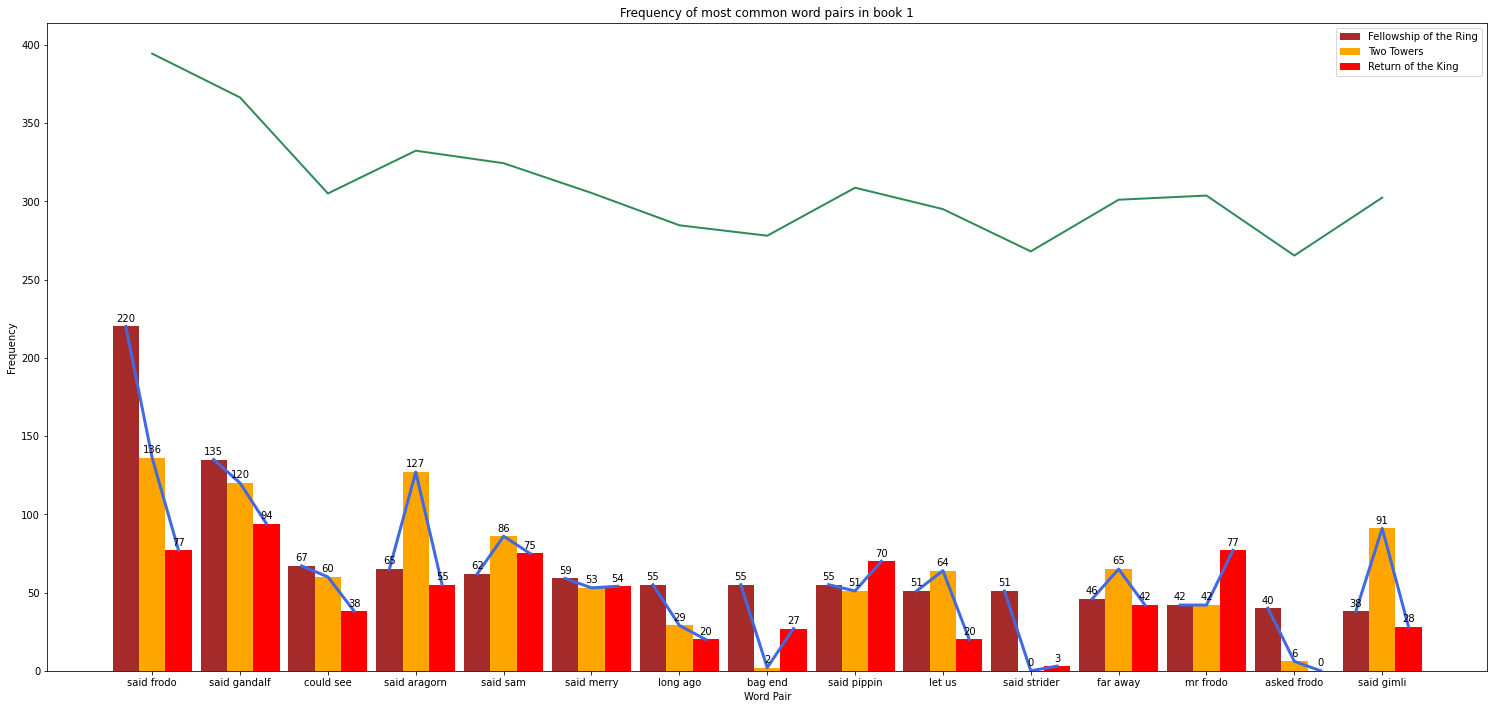

In [175]:
bar3(X, y1,y2,y3,
        'Frequency of most common word pairs in book 1',
        "Frequency","Word Pair", ["Fellowship of the Ring","Two Towers","Return of the King"], 
        w=1.5, scale=5)